In [2]:
import numpy as np
from scipy.optimize import linprog
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
def NN2NA(NN):
  rows,columns=NN.shape

  columns_NA=np.count_nonzero(NN)
  if(rows != columns):
    print("Malformed NN Matrix. rows are not equal to columns")
    return none,none
  k=0
  NA=np.zeros((rows,columns_NA))
  arches = ["" for i in range(columns_NA)]

  for i in range(columns):
    for j in range(rows):
      if NN[i,j]==1:
        NA[i,k]=1
        NA[j,k]=-1
        #if i==0:
        #  arches[k]="s->"+str(j+1)
        #elif j==0:
        #  arches[k]=str(i+1)+"->s"
        #elif i==columns-1:
        #  arches[k]="t->"+str(j+1)
        #elif j==columns-1:
        #  arches[k]=str(i+1)+"->t"
        #else:
        #  arches[k]=str(i+1)+"->"+str(j+1)
        arches[k]=str(i+1)+"->"+str(j+1)
        k+=1
  return NA, arches


def get_usage_string(arc_idxs, res_flow, capacity):
    return {arc: '%s/%s' % (flow, cap) for arc, flow, cap in zip(arc_idxs, res_flow, capacity)}

def get_min_cut(arc_idxs, np_res_flow, np_capacity):
    np_capacity = np.where(np_capacity == None, 999, np_capacity)

    idxs = np.argwhere((np_res_flow - np_capacity) == 0)
    return [arc_idxs[i[0]] for i in idxs]


def get_selected_arcs(arc_idxs, selected_arcs):
    arc = []
    for idx, i in enumerate(selected_arcs):
        if np.isclose(i, 1, rtol=1e-05, atol=1e-08, equal_nan=False): # Vecinity
            arc.append(arc_idxs[idx])
    return arc

In [4]:

NN = np.array([[0, 1, 1, 0, 0, 0],
               [0, 0, 0, 1, 0, 1],
               [0, 0, 0, 0, 1, 0],
               [0, 0, 0, 0, 0, 1],
               [0, 0, 0, 0, 0, 1],
               [0, 0, 0, 0, 0, 0]])


C = np.array([2, 2, 2, 5, 2, 1, 2])

Aeq, arc_idxs = NN2NA(NN)
beq = np.array([1, 0, 0, 0, 0, -1])

max_q=None
bounds = tuple([(0, max_q) for arcs in range(0, Aeq.shape[1])])
t = [np.array([3, 1, 3, 1, 3, 3, 5])]
#t = np.transpose(t)

T=8


print('## Optimizer inputs ## \n'
      'Cost vector: %s \n\n '
      'Arches in order:\n%s \n\n'
      'A_eq Node-Arc matrix:\n%s \n\n'
      'b_eq demand-supply vector: %s \n\n'
      'Bounds of each X arc variable: %s' % (C,arc_idxs,Aeq, beq, bounds))

## Optimizer inputs ## 
Cost vector: [2 2 2 5 2 1 2] 

 Arches in order:
['1->2', '1->3', '2->4', '2->6', '3->5', '4->6', '5->6'] 

A_eq Node-Arc matrix:
[[ 1.  1.  0.  0.  0.  0.  0.]
 [-1.  0.  1.  1.  0.  0.  0.]
 [ 0. -1.  0.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.]
 [ 0.  0.  0. -1.  0. -1. -1.]] 

b_eq demand-supply vector: [ 1  0  0  0  0 -1] 

Bounds of each X arc variable: ((0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  if sys.path[0] == '':


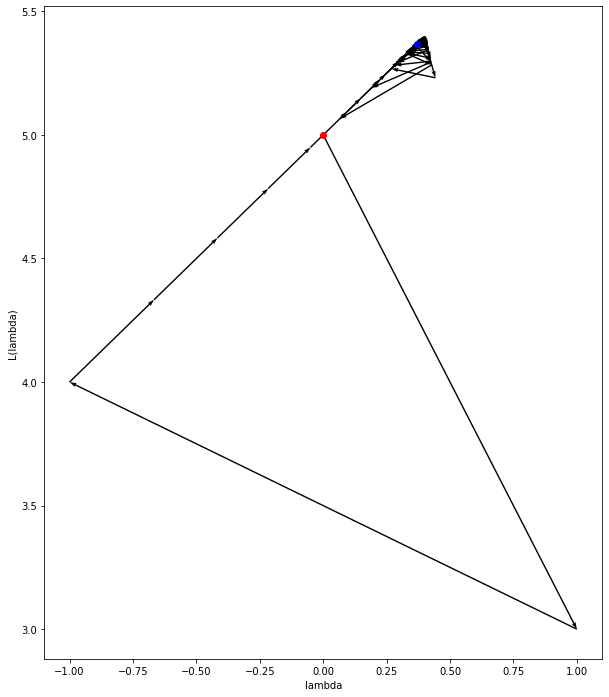

The max L is: 5.399885329081693 and correspond to l= 0.3998853290816935
The tolerance is: 0.01 and the results were obtained after 101 iterations


In [87]:
l_prev=0
l=0
tol=0.01
L_values=[]
l_values=[]
i=0
diff=np.inf


while (diff>tol and i<10000):
  C_=C+np.multiply(t,l)
  res = linprog(C_, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')
  L=(res.fun-l*T)
  delta_L=np.dot(t,res.x)-T
  i+=1
  step=1/i
  l_values=np.append(l_values,l)
  L_values=np.append(L_values,L)
  l_prev=l
  l=l_prev+step*delta_L
  diff=np.absolute(l-l_prev)
  if i==1000:print('Algorithm ended because 10000 iterations reached ')

plt.figure()
x=l_values
y=L_values
plt.rcParams["figure.figsize"] = (10,12)
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, width=0.0025)
plt.scatter(x[0],y[0],color='r')
plt.scatter(x[-1],y[-1],color='b')
plt.xlabel("lambda")
plt.ylabel("L(lambda)")
plt.show()


Max_L=np.max(L_values)
index=np.argmax(L_values)
Max_l=l_values[index]
print("The max L is:",Max_L, "and correspond to l=",Max_l)
print("The tolerance is:",tol,"and the results were obtained after",i,"iterations")



In [86]:
C_=C+np.multiply(t,l)
res = linprog(C_, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')

selarcs = get_selected_arcs(arc_idxs, res.x)


total_time=0
for i in selarcs:
  index=arc_idxs.index(i)
  total_time= total_time+t[0][index]

print('The arches are:          :',arc_idxs)
print('The raw solution will be:    %s' % res.x)
print('The arcs that make the shortest path will be (from, to): %s' % selarcs)
print('The minimum cost of this function that considerds lamda will be: %0.2f (it is not representative of the original problem)' % res.fun)
print('The time will be:',total_time,'\n\n')
print('The algorithm does not resolve ok the problem.')

The max L is: 5.399885329081693 and correspond to l= 0.3998853290816935
The arches are:          : ['1->2', '1->3', '2->4', '2->6', '3->5', '4->6', '5->6']
The raw solution will be:    [1. 0. 1. 0. 0. 1. 0.]
The arcs that make the shortest path will be (from, to): ['1->2', '2->4', '4->6']
The minimum cost of this function that considerds lamda will be: 8.40 (it is not representative of the original problem)
The time will be: 9 


The algorithm does not resolve ok the problem.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  import sys
